# 敵対的生成モデル(GAN)

**お互いが切磋琢磨しながら成長していくニューラルネットワーク**

### 偽札と偽札判別機

よく例えられるのが、**「偽札と偽札判別機」**　です。
2つのニューラルネットワークを生成し、それぞれ成長していきます。

+ ジェネレーター（generator）：偽物を作ります。
+ ディスクリミネータ（discriminator）：偽物を見破ります。

＊画像認識の場面でよく用いられるので、勘違いされがちですが、CNNのような2次元構造ではなく、ジェネレーターもディスクリミネータも通常のニューラルネットです。

In [1]:
# 必要ライブラリのimport
import numpy as np
from tqdm import tqdm # 進捗状況可視化
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense,Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras import optimizers
from keras import losses
from keras import initializers

Using TensorFlow backend.


## データセットの作成

今回はMNISTを使用します。

In [2]:
# 読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# -1~1の値域に変形
X_train = (X_train.astype(np.float32) - 127.5)/127.5
# フラットにする
X_train = X_train.reshape(60000, 784)

# 重み更新法

In [3]:
adam = optimizers.Adam(lr=0.0002, beta_1=0.5)

Instructions for updating:
Colocations handled automatically by placer.


## ジェネレータ―の生成

In [4]:
generator = Sequential()
generator.add(Dense(256, input_dim=100, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss=losses.binary_crossentropy, optimizer=adam)

## ディスクリミネータの生成

In [5]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss=losses.binary_crossentropy, optimizer=adam)

## ジェネレータとディスクリミネータの結合

In [6]:
# ディスクリミネータは学習しない(GAN内でのディスクリミネータは学習させない)
# →ディスクリミネータの単独学習はさせる
discriminator.trainable = False

# ジェネレータ―の入力
ganInput = Input(shape=(100,))
x = generator(ganInput)

# ディスクリミネータの入力
ganOutput = discriminator(x)

# 結合モデルの作成（100　→　1）
gan = Model(inputs=ganInput, outputs=ganOutput)

# コンパイル
gan.compile(loss=losses.binary_crossentropy, optimizer=adam)

## それぞれの損失格納

In [7]:
dLosses = []
gLosses = []

# 関数定義

+ 学習過程描画
+ 生成画像描画
+ モデル保存

In [8]:
def plotLoss():
    """最終的な損失をプロット
    """
    # 画像サイズ
    plt.figure(figsize=(10, 8))
    # 凡例
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    # 軸名
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # 保存
    plt.savefig('images/gan_loss_epoch.png' % epoch)

In [9]:
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    """現在の生成された画像を表示
    引数：
    　epoch：現在の学習回数
    　examples：描画するサンプル数
    　dim：縦数×横数
    　figsize：1画像のサイズ
    返り値：
    処理概要：
    　デフォルトだと、10×10ピクセルのMNIST画像を、10×10個ずつ合計100個並べた画像を出力する
    """
    # 生成したい画像の数のベクトル生成（100×100）
    noise = np.random.normal(0, 1, size=[examples, 100])
    
    # 上記のランダムな配列から、配列生成（100×784）
    generatedImages = generator.predict(noise)
    
    # 2次元に変換（100×28×28）
    generatedImages = generatedImages.reshape(examples, 28, 28)
    
    # 画像生成
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):# 100枚描画
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

In [10]:
def saveModels(epoch):
    """モデルを保存する
    引数：
    　epoch：現在の学習回数
    処理概要：
    　
    """
    generator.save('model/gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('model/gan_discriminator_epoch_%d.h5' % epoch)

# 学習

いよいよジェネレータとディスクリミネータを「敵対的に」学習させていきます。

## 学習順序

### 1.実際のデータでベクトルを生成する→正解ラベルを1とする

### 2.ジェネレータで偽ベクトルを生成する→正解ラベルを0とする

### 3.上記2つ(1,2)のベクトルを用いて、ディスクリミネータを学習させる

### 4.ベクトルをランダムに定義する→正解ラベルを1とする

### 5.上記のベクトル(4)を用いて、先ほど生成したGANのディスクリミネータの学習をOFFにして、ジェネレータのみ学習させる

**ディスクリミネータは、「ジェネレータが生成したベクトル」に対しては、0を出力するように学習している。**

**ディスクリミネータは、「実際のベクトル」に対しては、1を出力するように学習している。**

**しかし、**

**ジェネレータの正解ラベルは1に設定してあるので、ジェネレータは、ディスクリミネータが「実際のベクトル」が入力されたと勘違いするように成長する**


<img src="./images/gan.png"  width="80%" style="position:relative;left:-10%;">



  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

--------------- Epoch 0 ---------------
Instructions for updating:
Use tf.cast instead.


  2%|█▌                                                                               | 10/500 [00:00<00:05, 94.32it/s]

--------------- Epoch 1 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.13it/s]

--------------- Epoch 2 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 95.24it/s]

--------------- Epoch 3 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.13it/s]

--------------- Epoch 4 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 97.06it/s]

--------------- Epoch 5 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.13it/s]

--------------- Epoch 6 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.12it/s]

--------------- Epoch 7 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.15it/s]

--------------- Epoch 8 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 93.44it/s]

--------------- Epoch 9 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 95.22it/s]

--------------- Epoch 10 ---------------


  4%|███▏                                                                             | 20/500 [00:00<00:04, 96.79it/s]

--------------- Epoch 11 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.13it/s]

--------------- Epoch 12 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 94.32it/s]

--------------- Epoch 13 ---------------


  4%|███▏                                                                             | 20/500 [00:00<00:04, 96.51it/s]

--------------- Epoch 14 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 90.09it/s]

--------------- Epoch 15 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 95.24it/s]

--------------- Epoch 16 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 95.22it/s]

--------------- Epoch 17 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 97.06it/s]

--------------- Epoch 18 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 94.31it/s]

--------------- Epoch 19 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 95.22it/s]

--------------- Epoch 20 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:04, 98.03it/s]

--------------- Epoch 21 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 92.59it/s]

--------------- Epoch 22 ---------------


  4%|███▏                                                                             | 20/500 [00:00<00:04, 96.80it/s]

--------------- Epoch 23 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 95.22it/s]

--------------- Epoch 24 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:04, 98.01it/s]

--------------- Epoch 25 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.12it/s]

--------------- Epoch 26 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 94.32it/s]

--------------- Epoch 27 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.14it/s]

--------------- Epoch 28 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 97.09it/s]

--------------- Epoch 29 ---------------


  4%|███▏                                                                             | 20/500 [00:00<00:05, 95.25it/s]

--------------- Epoch 30 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 95.24it/s]

--------------- Epoch 31 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 95.24it/s]

--------------- Epoch 32 ---------------


  4%|███▏                                                                             | 20/500 [00:00<00:05, 95.86it/s]

--------------- Epoch 33 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.13it/s]

--------------- Epoch 34 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 95.24it/s]

--------------- Epoch 35 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.15it/s]

--------------- Epoch 36 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.15it/s]

--------------- Epoch 37 ---------------


  4%|███▏                                                                             | 20/500 [00:00<00:04, 96.24it/s]

--------------- Epoch 38 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 97.09it/s]

--------------- Epoch 39 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.12it/s]

--------------- Epoch 40 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.14it/s]

--------------- Epoch 41 ---------------


  4%|███▏                                                                             | 20/500 [00:00<00:04, 96.80it/s]

--------------- Epoch 42 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 95.21it/s]

--------------- Epoch 43 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 95.27it/s]

--------------- Epoch 44 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 97.09it/s]

--------------- Epoch 45 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.16it/s]

--------------- Epoch 46 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 97.07it/s]

--------------- Epoch 47 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.15it/s]

--------------- Epoch 48 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 95.24it/s]

--------------- Epoch 49 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.13it/s]

--------------- Epoch 50 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.16it/s]

--------------- Epoch 51 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 97.06it/s]

--------------- Epoch 52 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.13it/s]

--------------- Epoch 53 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 95.24it/s]

--------------- Epoch 54 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 94.34it/s]

--------------- Epoch 55 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 94.31it/s]

--------------- Epoch 56 ---------------


  4%|███▏                                                                             | 20/500 [00:00<00:05, 95.50it/s]

--------------- Epoch 57 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 94.34it/s]

--------------- Epoch 58 ---------------


  4%|███▏                                                                             | 20/500 [00:00<00:04, 96.43it/s]

--------------- Epoch 59 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 95.24it/s]

--------------- Epoch 60 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 91.72it/s]

--------------- Epoch 61 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.13it/s]

--------------- Epoch 62 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 91.72it/s]

--------------- Epoch 63 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:04, 98.01it/s]

--------------- Epoch 64 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 92.57it/s]

--------------- Epoch 65 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.15it/s]

--------------- Epoch 66 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 93.44it/s]

--------------- Epoch 67 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 94.34it/s]

--------------- Epoch 68 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.15it/s]

--------------- Epoch 69 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.16it/s]

--------------- Epoch 70 ---------------


  4%|███▏                                                                             | 20/500 [00:00<00:05, 95.86it/s]

--------------- Epoch 71 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.01it/s]

--------------- Epoch 72 ---------------


  4%|███▏                                                                             | 20/500 [00:00<00:05, 94.70it/s]

--------------- Epoch 73 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 94.32it/s]

--------------- Epoch 74 ---------------


  4%|███▏                                                                             | 20/500 [00:00<00:04, 96.51it/s]

--------------- Epoch 75 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 93.45it/s]

--------------- Epoch 76 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 94.34it/s]

--------------- Epoch 77 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 94.32it/s]

--------------- Epoch 78 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 93.44it/s]

--------------- Epoch 79 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 95.22it/s]

--------------- Epoch 80 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.15it/s]

--------------- Epoch 81 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.16it/s]

--------------- Epoch 82 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 94.34it/s]

--------------- Epoch 83 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 91.74it/s]

--------------- Epoch 84 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.15it/s]

--------------- Epoch 85 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 92.59it/s]

--------------- Epoch 86 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 95.24it/s]

--------------- Epoch 87 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 92.57it/s]

--------------- Epoch 88 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.13it/s]

--------------- Epoch 89 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 94.31it/s]

--------------- Epoch 90 ---------------


  4%|███▏                                                                             | 20/500 [00:00<00:04, 96.51it/s]

--------------- Epoch 91 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 97.09it/s]

--------------- Epoch 92 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 94.31it/s]

--------------- Epoch 93 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.13it/s]

--------------- Epoch 94 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 94.34it/s]

--------------- Epoch 95 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 91.74it/s]

--------------- Epoch 96 ---------------


  2%|█▌                                                                               | 10/500 [00:00<00:05, 93.46it/s]

--------------- Epoch 97 ---------------


  2%|█▍                                                                                | 9/500 [00:00<00:05, 89.11it/s]

--------------- Epoch 98 ---------------


  2%|█▍                                                                                | 9/500 [00:00<00:05, 83.33it/s]

--------------- Epoch 99 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 95.28it/s]


NameError: name 'epoch' is not defined

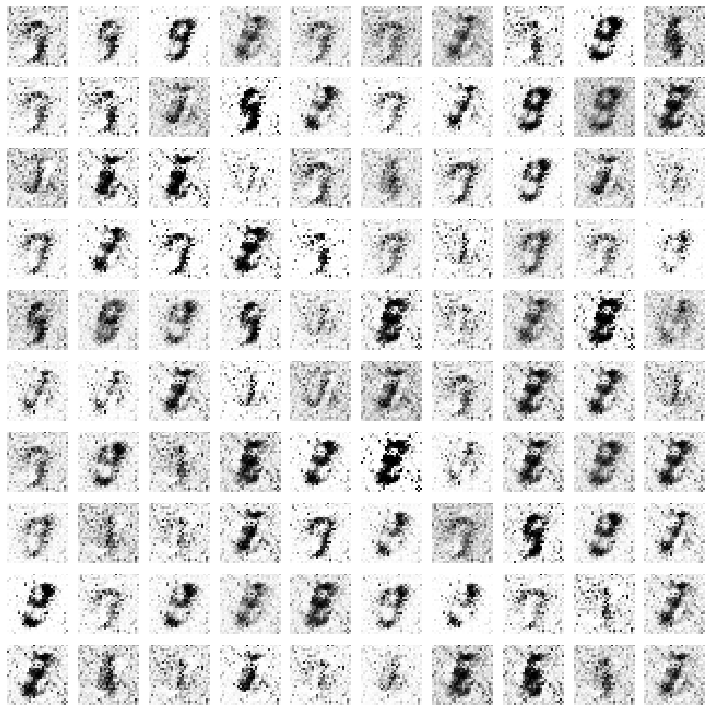

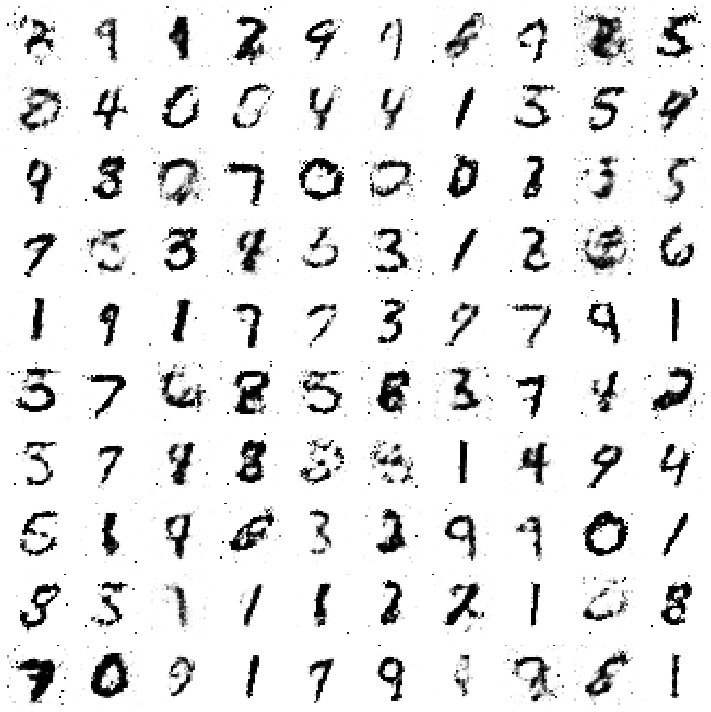

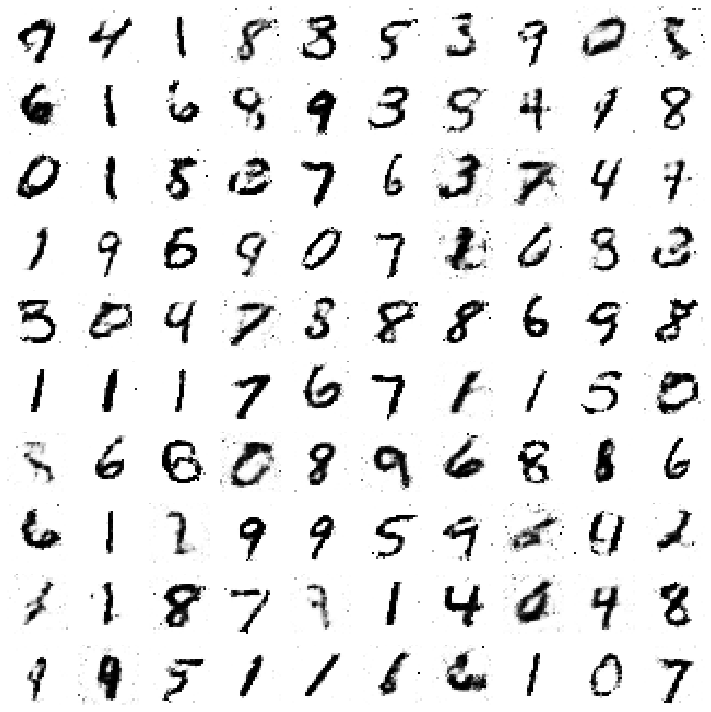

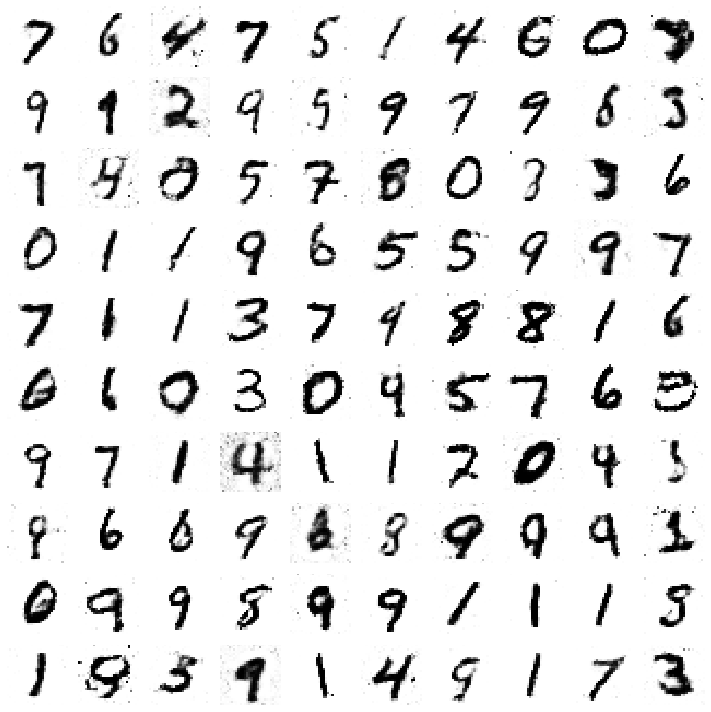

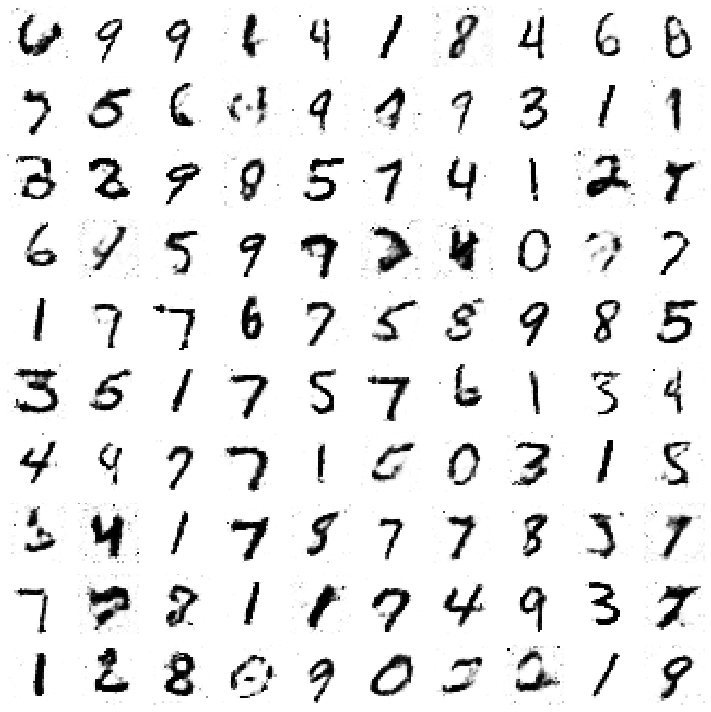

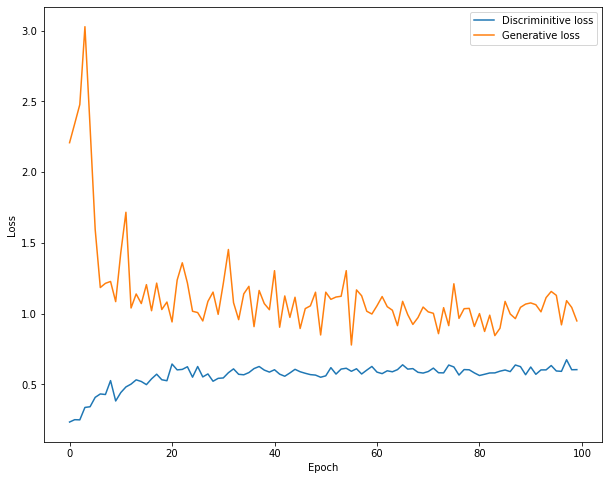

In [11]:
epochs=100
for e in range(epochs):
    # 学習回数の描画
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for _ in tqdm(range(500)):# 進捗状況の可視化
        ########### 1
        # ランダムにバッチ数の数だけ訓練データを取得(128×784)
        img = X_train[np.random.randint(0, 60000, size=128)]
        ########### 2
        # 生成したい画像の数の画像生成（128×100）
        noise = np.random.normal(0, 1, size=[128, 100])
        # ジェネレータで画像を生成（128×784）
        img_gen = generator.predict(noise)
        # 上記2配列の結合（256×784）
        X = np.concatenate([img,img_gen])
        # ディスクリミネータの正解ラベル
        y_img = np.ones(128)
        y_img_gen = np.zeros(128)
        y = np.concatenate([y_img,y_img_gen])
        ########### 3
        # ディスクリミネータの学習
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, y)
        ########### 4
        # 生成したい画像の数のベクトル生成（128×100）
        noise = np.random.normal(0, 1, size=[128, 100])
        # ジェネレータの正解ラベル
        y = np.ones(128)
        ########### 5
        # ディスクリミネイタの学習をOFFにする
        discriminator.trainable = False
        # ジェネレータを学習させる
        gloss = gan.train_on_batch(noise, y)

    # ジェネレータとディスクリミネイターの損失を保存
    dLosses.append(dloss)
    gLosses.append(gloss)
    
    # 定期的に出力
    if e % 20 == 0:
        # ジェネレータ生成画像の出力
        plotGeneratedImages(e)
        # モデルの出力
        saveModels(e)

# 学習過程の出力
plotLoss()